In [86]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol

Definition of ODEs

In [87]:
# set beforehand mu, gamma and kill function params
mu = 10
gamma = 1
fk_max = 5
R_k = 0.5


def model(t, z, alpha_1, alpha_2, v_1, v_2):

    dAdt = -alpha_1*(1 - z[1])*z[0]*z[2] + alpha_2*gamma*z[1]*z[2]
    dRdt = (alpha_1/gamma)*(1 - z[1])*z[0] - alpha_2*z[1]
    dSdt = -(fk_max*(z[1]/(z[1] + R_k)))*z[3]
    dCdt = v_1*((mu/20) - z[3])*(z[2] - z[3]) - v_2*z[3] - (fk_max*(z[1]/(z[1] + R_k)))*z[3]
    dzdt = [dAdt, dRdt, dSdt, dCdt]

    return dzdt

# default param values
alpha_1 = 1e-3
alpha_2 = 1.2
v_1 = 1.2e2
v_2 = 14.4 *1e-1

# initial condition and time steps/span
z0 = [1, 0, 1, 0]
t= np.geomspace(0.000001, 1, 1000)
t_span = [0.000001, 1]

# exampple solution calculation
z = solve_ivp(model, t_span, z0, args =(alpha_1, alpha_2, v_1, v_2), method ='Radau', t_eval = t)

Sobol analysis

In [88]:
problem = {
    'num_vars': 4,
    'names': ['alpha_1', 'alpha_2', 'v_1', 'v_2'],
    'bounds': np.column_stack((np.array([5.8e-6/0.5, alpha_2, v_1, v_2])*0.5, np.array([5.8e2/1.5, alpha_2, v_1, v_2])*1.5))
}

# generate samples
vals = saltelli.sample(problem, 1024)

# initialize matrix to store output
Y = np.zeros([len(vals), 4, 1000])

# run model
for i in range(len(vals)):
    sol = solve_ivp(model, t_span, z0, args =(vals[i][0], vals[i][1], vals[i][2], vals[i][3]), method ='Radau', t_eval = t)
    Y[i][0][:] = sol.y[0]
    Y[i][1][:] = sol.y[1]
    Y[i][2][:] = sol.y[2]
    Y[i][3][:] = sol.y[3]

In [89]:
Si = sobol.analyze(problem, Y[:, 2, -1], print_to_console=True)


               ST   ST_conf
alpha_1  0.928955  0.090504
alpha_2  0.005341  0.005813
v_1      0.074705  0.073459
v_2      0.013093  0.012574
               S1   S1_conf
alpha_1  0.926101  0.749828
alpha_2  0.001938  0.003190
v_1      0.076077  0.067568
v_2      0.006304  0.015279
                          S2   S2_conf
(alpha_1, alpha_2)  0.018399  1.484033
(alpha_1, v_1)      0.005932  1.500327
(alpha_1, v_2)      0.004148  1.471908
(alpha_2, v_1)     -0.000607  0.003488
(alpha_2, v_2)     -0.000491  0.003036
(v_1, v_2)         -0.011783  0.034494


Plot for sobolev indicies over time 

In [90]:
alpha_1_sobol = np.zeros(500)
alpha_2_sobol = np.zeros(500)
v_1_sobol = np.zeros(500)
v_2_sobol = np.zeros(500)

# calculate total order sobol indicies for alpha_1 at each time step
for i in range(len(alpha_1_sobol)):
    Si = sobol.analyze(problem, Y[:, 2, i])
    alpha_1_sobol[i] = Si['ST'][0]
    alpha_2_sobol[i] = Si['ST'][1]
    v_1_sobol[i] = Si['ST'][2]
    v_2_sobol[i] = Si['ST'][3]

/home/sabsr3/.local/lib/python3.8/site-packages/SALib/analyze/sobol.py:96: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


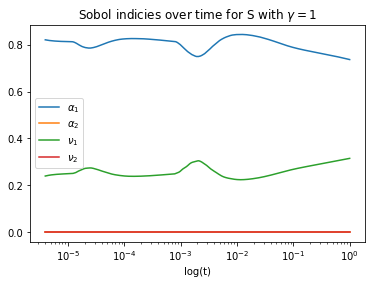

In [93]:
t= np.geomspace(0.000001, 1, 500)
t = t[50:]
plt.semilogx(t, alpha_1_sobol[50:], label = r'$\alpha_1$')
plt.semilogx(t, alpha_2_sobol[50:], label = r'$\alpha_2$')
plt.semilogx(t, v_1_sobol[50:], label = r'$\nu_1$')
plt.semilogx(t, v_2_sobol[50:], label = r'$\nu_2$')
plt.xlabel('log(t)')
plt.title(r'Sobol indicies over time for S with $\gamma = 1$')
plt.legend(loc='best')
plt.show()